In [2]:
import numpy as np 
import pandas as pd 

In [3]:
CLEAN_TWEETS = False

In [4]:
import numpy as np
import pandas as pd
import os, re
import tensorflow as tf
import matplotlib.pyplot as plt

2024-04-03 11:38:17.025941: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
!pip install torch

In [6]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [7]:
df = pd.read_csv('./train_hu.csv',encoding='latin-1')

print('Number of training sentences: {:,}\n'.format(df.shape[0]))
# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 7,741



,tweet,class
6506,legalább én nem fekete ribanc a szüleid hagyt...,0
7123,"""Gyakorlatilag minden, ami vörösre színez?dik,...",2
4618,"Ebb?l a tweetb?l is látszik, hogy egy pöcs vagy.",1
3299,ribanc Én csinálom a terveket nem te punci fi...,1
3223,én pissed sok ppl ki a fb én voltam elárasztj...,1
6099,"Lmaoooooo ez a ribanc úgy néz ki, mint",1
7125,éjszakai jigaboo,2
4191,"Azt hiszem, látnom kell a szóban forgó ribancot.",1
6430,ribanc találkozó,1
917,ribanc,1


In [8]:
df.groupby('class').count()

,tweet
class,
0,648
1,5761
2,1331


In [9]:
#strip tweet related character
def strip_all_entities(x):
    return ' '.join(re.sub("['!`\".?,:]+", " ", x).split())

#check functionality
print(df['tweet'][1])
strip_all_entities(df['tweet'][1])

 RT Dawg RT : Dugtál már valaha egy ribancot, és ? elkezdett sírni? Összezavarodtál, mint a szar


'RT Dawg RT Dugtál már valaha egy ribancot és elkezdett sírni Összezavarodtál mint a szar'

In [10]:
df['tweet']=df['tweet'].apply(str)

In [11]:
if CLEAN_TWEETS == False:
    df['tweet']=df['tweet'].apply(strip_all_entities)

In [12]:
sentences = df['tweet'].values
labels = df['class'].values

In [13]:
!pip install scikit-learn

In [14]:
from sklearn.model_selection import train_test_split

train, Teal = train_test_split(df, random_state=1508, shuffle=True, test_size=0.2)

In [15]:
test, validation = train_test_split(Teal, random_state=1508, shuffle=True, test_size=0.5)

In [16]:
# Get the lists of sentences and their labels.
trn_sentences = train['tweet'].values
train_labels = train['class'].values

tst_sentences = test['tweet'].values
test_labels = test['class'].values

val_sentences = validation['tweet'].values
validation_labels = validation['class'].values

In [17]:
#Tokenization

In [18]:
from transformers import BertTokenizer

print('loading Multilangual Bert tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=True)

loading Multilangual Bert tokenizer...


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [19]:
enc_exp = tokenizer.encode('Az en nevem Nándi')
dec_exp = tokenizer.decode(enc_exp)
print(enc_exp)
print(dec_exp)

[101, 10360, 10110, 31923, 10147, 10799, 10703, 102]
[CLS] az en nevem nandi [SEP]


In [20]:
print('Max array length: ', max([len(i) for i in sentences]))

Max array length:  184


In [21]:
count1, count2, count3 = 0, 0, 0
for i in sentences:
    if len(i)>100:
        count1+=1
    if len(i)>200:
        count2+=1
    if len(i)>300:
        count3+=1
print('number of array longer than 100: ', count1)
print('number of array longer than 200: ', count2)
print('number of array longer than 300: ', count3)

number of array longer than 100:  1298
number of array longer than 200:  0
number of array longer than 300:  0


In [22]:
def bert_encode(data, max_len) :
    input_ids = []
    attention_masks = []
  

    for i in range(len(data)):
        encoded = tokenizer.encode_plus(data[i],
                                        add_special_tokens=True,
                                        max_length = max_len,
                                        padding = 'max_length',
                                        truncation = True,
                                        return_attention_mask=True)
      
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

In [23]:
print(len(sentences),len(trn_sentences),len(tst_sentences),len(val_sentences))

7741 6192 774 775


In [24]:
MAX_LEN = 64
train_inputs, train_masks = bert_encode(trn_sentences,MAX_LEN)

#test_inputs, test_masks = bert_encode(tst_sentences,MAX_LEN)

validation_inputs, validation_masks = bert_encode(val_sentences,MAX_LEN)

In [25]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [26]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [27]:
#BERT for sequence classification

In [28]:
from transformers import BertForSequenceClassification, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [29]:
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8) # args.adam_epsilon  - default is 1e-8.

In [30]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [31]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [32]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [33]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

        # The call to `model` always returns a tuple, so we need to pull the
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
            
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    194.    Elapsed: 0:00:14.
  Batch    80  of    194.    Elapsed: 0:00:27.
  Batch   120  of    194.    Elapsed: 0:00:40.
  Batch   160  of    194.    Elapsed: 0:00:53.

  Average training loss: 0.61
  Training epcoh took: 0:01:05

Running Validation...
  Accuracy: 0.83
  Validation took: 0:00:03

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    194.    Elapsed: 0:00:13.
  Batch    80  of    194.    Elapsed: 0:00:27.
  Batch   120  of    194.    Elapsed: 0:00:40.
  Batch   160  of    194.    Elapsed: 0:00:53.

  Average training loss: 0.39
  Training epcoh took: 0:01:05

Running Validation...
  Accuracy: 0.83
  Validation took: 0:00:03

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    194.    Elapsed: 0:00:13.
  Batch    80  of    194.    Elapsed: 0:00:27.
  Batch   120  of    194.    Elapsed: 0:00:40.
  Batch   160  of    194.    Elapsed: 0:00:54.

  Average training loss: 0.31
  Training epcoh t

In [34]:
!pip install seaborn

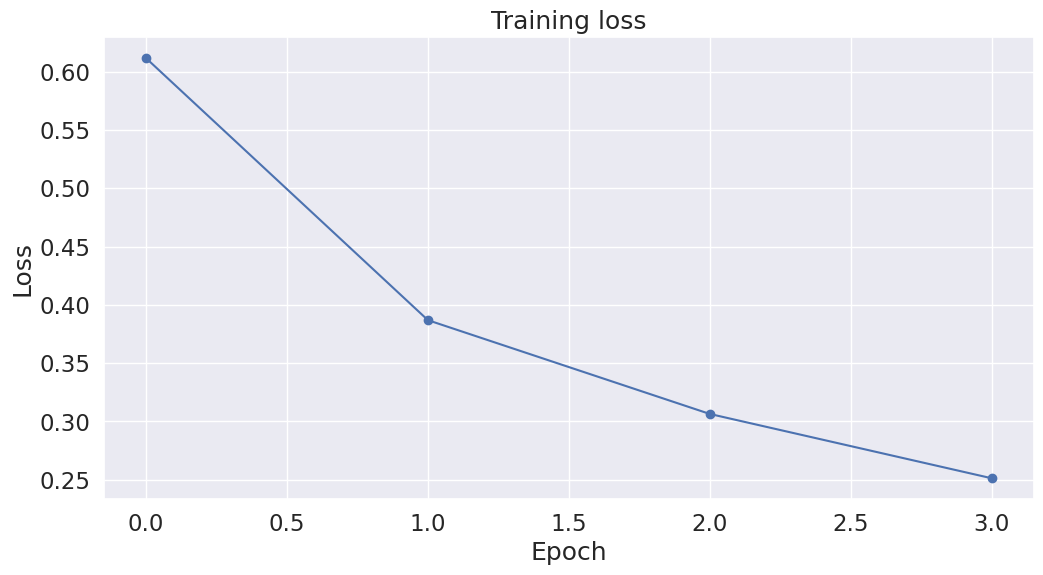

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [36]:
#On test set

In [37]:
test_inputs, test_masks = bert_encode(tst_sentences,MAX_LEN)

# Convert to tensors.
prediction_inputs = torch.tensor(test_inputs)
prediction_masks = torch.tensor(test_masks)
prediction_labels = torch.tensor(test_labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [38]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 774 test sentences...
    DONE.


In [39]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 3-column ndarray (one column for "0" 
  # one for "1" and one for "2"). Pick the label with the highest value and turn this
  # in to a list of 0s, 1s, 2s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

In [40]:
#Calculating Matthews Corr. Coef. for each batch...

In [41]:
# Combine the predictions for each batch into a single list of 0s,1s, 2s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.558


In [42]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, flat_predictions))

              precision    recall  f1-score   support

           0       0.52      0.31      0.39        78
           1       0.88      0.91      0.89       577
           2       0.68      0.76      0.72       119

    accuracy                           0.82       774
   macro avg       0.69      0.66      0.67       774
weighted avg       0.81      0.82      0.82       774

